In [1]:
import random
import numpy as np
import sys
import gym
import torch
import pylab
from collections import deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms


In [2]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [3]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    #a = 0.6
    #beta = 0.4    

    def __init__(self, capacity, a, beta, beta_increment_per_sampling):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.a = a
        self.beta = beta
        self.beta_increment_per_sampling = beta_increment_per_sampling

    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(sampling_probabilities, -self.beta)
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)


In [4]:
EPISODES = 100
NUM_SIM = 30

# approximate Q function using Neural Network
# state is input and Q Value of each action is output of network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128),                        
            nn.ReLU(),
            nn.Linear(128, action_size),
        )

    def forward(self, x):
        return self.fc(x)


# DQN Agent for the Cartpole
# it uses Neural Network to approximate q function
# and prioritized experience replay memory & target q network
class DQNAgent():
    def __init__(self, state_size, action_size, a, beta, beta_increment_per_sampling):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters for the DQN
        self.discount_factor = 0.8
        self.learning_rate = 0.001
        self.memory_size = 10000
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.explore_step = 1000
        self.epsilon_decay = (self.epsilon - self.epsilon_min) / self.explore_step
        self.batch_size = 64
        self.train_start = 0

        # create prioritized replay memory using SumTree
        self.memory = Memory(self.memory_size, a, beta, beta_increment_per_sampling)

        # create main model and target model
        self.model = DQN(state_size, action_size)
        self.model.apply(self.weights_init)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(),
                                    lr=self.learning_rate)

        # initialize target model
        self.update_target_model()

        if self.load_model:
            self.model = torch.load('save_model/cartpole_dqn')

    # weight xavier initialize
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            torch.nn.init.xavier_uniform(m.weight)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # get action from model using epsilon-greedy policy
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.from_numpy(state)
            state = Variable(state).float().cpu()
            q_value = self.model(state)
            _, action = torch.max(q_value, 1)
            return int(action)

    # save sample (error,<s,a,r,s'>) to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        target = self.model(Variable(torch.FloatTensor(state))).data
        old_val = target[0][action]
        target_val = self.target_model(Variable(torch.FloatTensor(next_state))).data
        if done:
            target[0][action] = reward
        else:
            target[0][action] = reward + self.discount_factor * torch.max(target_val)

        error = abs(old_val - target[0][action])

        self.memory.add(error, (state, action, reward, next_state, done))

    # pick samples from prioritized replay memory (with batch_size)
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        mini_batch, idxs, is_weights = self.memory.sample(self.batch_size)
        mini_batch = np.array(mini_batch).transpose()

        states = np.vstack(mini_batch[0])
        actions = list(mini_batch[1])
        rewards = list(mini_batch[2])
        next_states = np.vstack(mini_batch[3])
        dones = mini_batch[4]

        # bool to binary
        dones = dones.astype(int)

        # Q function of current state
        states = torch.Tensor(states)
        states = Variable(states).float()
        pred = self.model(states)

        # one-hot encoding
        a = torch.LongTensor(actions).view(-1, 1)

        one_hot_action = torch.FloatTensor(self.batch_size, self.action_size).zero_()
        one_hot_action.scatter_(1, a, 1)

        pred = torch.sum(pred.mul(Variable(one_hot_action)), dim=1)

        # Q function of next state
        next_states = torch.Tensor(next_states)
        next_states = Variable(next_states).float()
        next_pred = self.target_model(next_states).data

        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        # Q Learning: get maximum Q value at s' from target model
        target = rewards + (1 - dones) * self.discount_factor * next_pred.max(1)[0]
        target = Variable(target)

        errors = torch.abs(pred - target).data.numpy()

        # update priority
        for i in range(self.batch_size):
            idx = idxs[i]
            self.memory.update(idx, errors[i])

        self.optimizer.zero_grad()

        # MSE Loss function
        is_weights = torch.from_numpy(is_weights).type(torch.FloatTensor)
        loss = F.mse_loss(is_weights* pred, is_weights* target)
        #loss = F.mse_loss(pred, target)
        loss.backward()

        # and train
        self.optimizer.step()

def P_simulation():     

    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v0')
    #env = gym.make('MountainCar-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    model = DQN(state_size, action_size)

    agent = DQNAgent(state_size, action_size, 0.4, 0.4, 0.000025)
    #agent1 = DQNAgent(state_size, action_size, 0,  1.0)
    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0

        state = env.reset()  
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            #reward = reward if not done or score == 499 else -10
            reward = reward 
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.memory.tree.n_entries >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                #score = score if score == 500 else score + 10
                scores.append(score)
                episodes.append(e)
                #pylab.plot(episodes, scores, 'b')
                #pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      agent.memory.tree.n_entries, "  epsilon:", agent.epsilon, " beta", agent.memory.beta)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #torch.save(agent.model, "./save_model/cartpole_dqn")
                    #sys.exit()

    return episodes, scores

P_episodess = []
P_scoress = []

for i in range(NUM_SIM):
    episodes, scores = P_simulation()
    P_episodess += [episodes]
    P_scoress += [scores]

/home/qwerthjkl45/miniconda3/envs/rl2018/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


episode: 0   score: 63.0   memory length: 63   epsilon: 0.9401499999999996  beta 0.40157499999999985
episode: 1   score: 17.0   memory length: 80   epsilon: 0.9239999999999995  beta 0.4019999999999998
episode: 2   score: 22.0   memory length: 102   epsilon: 0.9030999999999993  beta 0.40254999999999974
episode: 3   score: 17.0   memory length: 119   epsilon: 0.8869499999999992  beta 0.4029749999999997
episode: 4   score: 13.0   memory length: 132   epsilon: 0.8745999999999992  beta 0.40329999999999966
episode: 5   score: 12.0   memory length: 144   epsilon: 0.8631999999999991  beta 0.4035999999999996
episode: 6   score: 44.0   memory length: 188   epsilon: 0.8213999999999988  beta 0.4046999999999995
episode: 7   score: 19.0   memory length: 207   epsilon: 0.8033499999999987  beta 0.40517499999999945
episode: 8   score: 19.0   memory length: 226   epsilon: 0.7852999999999986  beta 0.4056499999999994
episode: 9   score: 19.0   memory length: 245   epsilon: 0.7672499999999984  beta 0.40612

episode: 80   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6891000000003881
episode: 81   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6941000000003986
episode: 82   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6991000000004092
episode: 83   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7041000000004197
episode: 84   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7091000000004303
episode: 85   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7141000000004408
episode: 86   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7191000000004514
episode: 87   score: 180.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7236000000004609
episode: 88   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7286000000004714
episode: 89   score: 192.0   memory length: 10000   eps

episode: 60   score: 200.0   memory length: 7109   epsilon: 0.0499999999999937  beta 0.577725000000153
episode: 61   score: 200.0   memory length: 7309   epsilon: 0.0499999999999937  beta 0.5827250000001636
episode: 62   score: 200.0   memory length: 7509   epsilon: 0.0499999999999937  beta 0.5877250000001741
episode: 63   score: 200.0   memory length: 7709   epsilon: 0.0499999999999937  beta 0.5927250000001847
episode: 64   score: 200.0   memory length: 7909   epsilon: 0.0499999999999937  beta 0.5977250000001952
episode: 65   score: 172.0   memory length: 8081   epsilon: 0.0499999999999937  beta 0.6020250000002043
episode: 66   score: 163.0   memory length: 8244   epsilon: 0.0499999999999937  beta 0.6061000000002129
episode: 67   score: 189.0   memory length: 8433   epsilon: 0.0499999999999937  beta 0.6108250000002229
episode: 68   score: 200.0   memory length: 8633   epsilon: 0.0499999999999937  beta 0.6158250000002334
episode: 69   score: 200.0   memory length: 8833   epsilon: 0.049

episode: 40   score: 67.0   memory length: 1539   epsilon: 0.0499999999999937  beta 0.4384749999999958
episode: 41   score: 76.0   memory length: 1615   epsilon: 0.0499999999999937  beta 0.4403749999999956
episode: 42   score: 92.0   memory length: 1707   epsilon: 0.0499999999999937  beta 0.4426749999999953
episode: 43   score: 69.0   memory length: 1776   epsilon: 0.0499999999999937  beta 0.44439999999999513
episode: 44   score: 37.0   memory length: 1813   epsilon: 0.0499999999999937  beta 0.44532499999999503
episode: 45   score: 83.0   memory length: 1896   epsilon: 0.0499999999999937  beta 0.4473999999999948
episode: 46   score: 155.0   memory length: 2051   epsilon: 0.0499999999999937  beta 0.4512749999999944
episode: 47   score: 40.0   memory length: 2091   epsilon: 0.0499999999999937  beta 0.45227499999999426
episode: 48   score: 137.0   memory length: 2228   epsilon: 0.0499999999999937  beta 0.4556999999999939
episode: 49   score: 102.0   memory length: 2330   epsilon: 0.049999

episode: 20   score: 60.0   memory length: 479   epsilon: 0.5449499999999969  beta 0.4119749999999987
episode: 21   score: 38.0   memory length: 517   epsilon: 0.5088499999999967  beta 0.4129249999999986
episode: 22   score: 36.0   memory length: 553   epsilon: 0.47464999999999646  beta 0.4138249999999985
episode: 23   score: 200.0   memory length: 753   epsilon: 0.2846499999999952  beta 0.41882499999999795
episode: 24   score: 142.0   memory length: 895   epsilon: 0.14974999999999428  beta 0.42237499999999756
episode: 25   score: 200.0   memory length: 1095   epsilon: 0.0499999999999937  beta 0.427374999999997
episode: 26   score: 200.0   memory length: 1295   epsilon: 0.0499999999999937  beta 0.43237499999999646
episode: 27   score: 126.0   memory length: 1421   epsilon: 0.0499999999999937  beta 0.4355249999999961
episode: 28   score: 109.0   memory length: 1530   epsilon: 0.0499999999999937  beta 0.4382499999999958
episode: 29   score: 114.0   memory length: 1644   epsilon: 0.049999

episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7636500000005454
episode: 0   score: 21.0   memory length: 21   epsilon: 0.9800499999999999  beta 0.40052499999999996
episode: 1   score: 46.0   memory length: 67   epsilon: 0.9363499999999996  beta 0.40167499999999984
episode: 2   score: 12.0   memory length: 79   epsilon: 0.9249499999999995  beta 0.4019749999999998
episode: 3   score: 30.0   memory length: 109   epsilon: 0.8964499999999993  beta 0.4027249999999997
episode: 4   score: 11.0   memory length: 120   epsilon: 0.8859999999999992  beta 0.4029999999999997
episode: 5   score: 15.0   memory length: 135   epsilon: 0.8717499999999991  beta 0.40337499999999965
episode: 6   score: 16.0   memory length: 151   epsilon: 0.856549999999999  beta 0.4037749999999996
episode: 7   score: 14.0   memory length: 165   epsilon: 0.843249999999999  beta 0.40412499999999957
episode: 8   score: 11.0   memory length: 176   epsilon: 0.8327999999999989  beta 0.4043

episode: 79   score: 161.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6635750000003342
episode: 80   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6685750000003448
episode: 81   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6735750000003553
episode: 82   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6785750000003659
episode: 83   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6835750000003764
episode: 84   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.688575000000387
episode: 85   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6935750000003975
episode: 86   score: 196.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6984750000004079
episode: 87   score: 176.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7028750000004171
episode: 88   score: 200.0   memory length: 10000   epsi

episode: 59   score: 178.0   memory length: 7171   epsilon: 0.0499999999999937  beta 0.5792750000001563
episode: 60   score: 176.0   memory length: 7347   epsilon: 0.0499999999999937  beta 0.5836750000001656
episode: 61   score: 192.0   memory length: 7539   epsilon: 0.0499999999999937  beta 0.5884750000001757
episode: 62   score: 187.0   memory length: 7726   epsilon: 0.0499999999999937  beta 0.5931500000001856
episode: 63   score: 198.0   memory length: 7924   epsilon: 0.0499999999999937  beta 0.598100000000196
episode: 64   score: 200.0   memory length: 8124   epsilon: 0.0499999999999937  beta 0.6031000000002066
episode: 65   score: 188.0   memory length: 8312   epsilon: 0.0499999999999937  beta 0.6078000000002165
episode: 66   score: 200.0   memory length: 8512   epsilon: 0.0499999999999937  beta 0.612800000000227
episode: 67   score: 200.0   memory length: 8712   epsilon: 0.0499999999999937  beta 0.6178000000002376
episode: 68   score: 200.0   memory length: 8912   epsilon: 0.0499

episode: 39   score: 200.0   memory length: 3562   epsilon: 0.0499999999999937  beta 0.4890499999999902
episode: 40   score: 200.0   memory length: 3762   epsilon: 0.0499999999999937  beta 0.49404999999998966
episode: 41   score: 200.0   memory length: 3962   epsilon: 0.0499999999999937  beta 0.4990499999999891
episode: 42   score: 200.0   memory length: 4162   epsilon: 0.0499999999999937  beta 0.5040499999999976
episode: 43   score: 168.0   memory length: 4330   epsilon: 0.0499999999999937  beta 0.5082500000000064
episode: 44   score: 200.0   memory length: 4530   epsilon: 0.0499999999999937  beta 0.513250000000017
episode: 45   score: 200.0   memory length: 4730   epsilon: 0.0499999999999937  beta 0.5182500000000275
episode: 46   score: 200.0   memory length: 4930   epsilon: 0.0499999999999937  beta 0.5232500000000381
episode: 47   score: 200.0   memory length: 5130   epsilon: 0.0499999999999937  beta 0.5282500000000486
episode: 48   score: 200.0   memory length: 5330   epsilon: 0.04

episode: 19   score: 22.0   memory length: 375   epsilon: 0.6437499999999976  beta 0.409374999999999
episode: 20   score: 18.0   memory length: 393   epsilon: 0.6266499999999975  beta 0.40982499999999894
episode: 21   score: 20.0   memory length: 413   epsilon: 0.6076499999999974  beta 0.4103249999999989
episode: 22   score: 16.0   memory length: 429   epsilon: 0.5924499999999973  beta 0.41072499999999884
episode: 23   score: 17.0   memory length: 446   epsilon: 0.5762999999999971  beta 0.4111499999999988
episode: 24   score: 30.0   memory length: 476   epsilon: 0.547799999999997  beta 0.4118999999999987
episode: 25   score: 11.0   memory length: 487   epsilon: 0.5373499999999969  beta 0.4121749999999987
episode: 26   score: 36.0   memory length: 523   epsilon: 0.5031499999999967  beta 0.4130749999999986
episode: 27   score: 32.0   memory length: 555   epsilon: 0.47274999999999645  beta 0.4138749999999985
episode: 28   score: 21.0   memory length: 576   epsilon: 0.4527999999999963  bet

episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6858250000003812
episode: 0   score: 12.0   memory length: 12   epsilon: 0.9885999999999999  beta 0.4003
episode: 1   score: 12.0   memory length: 24   epsilon: 0.9771999999999998  beta 0.40059999999999996
episode: 2   score: 26.0   memory length: 50   epsilon: 0.9524999999999997  beta 0.4012499999999999
episode: 3   score: 28.0   memory length: 78   epsilon: 0.9258999999999995  beta 0.4019499999999998
episode: 4   score: 13.0   memory length: 91   epsilon: 0.9135499999999994  beta 0.40227499999999977
episode: 5   score: 51.0   memory length: 142   epsilon: 0.8650999999999991  beta 0.40354999999999963
episode: 6   score: 11.0   memory length: 153   epsilon: 0.854649999999999  beta 0.4038249999999996
episode: 7   score: 21.0   memory length: 174   epsilon: 0.8346999999999989  beta 0.40434999999999954
episode: 8   score: 31.0   memory length: 205   epsilon: 0.8052499999999987  beta 0.40512499999999946

episode: 79   score: 64.0   memory length: 8869   epsilon: 0.0499999999999937  beta 0.6217250000002459
episode: 80   score: 198.0   memory length: 9067   epsilon: 0.0499999999999937  beta 0.6266750000002563
episode: 81   score: 200.0   memory length: 9267   epsilon: 0.0499999999999937  beta 0.6316750000002669
episode: 82   score: 183.0   memory length: 9450   epsilon: 0.0499999999999937  beta 0.6362500000002765
episode: 83   score: 164.0   memory length: 9614   epsilon: 0.0499999999999937  beta 0.6403500000002852
episode: 84   score: 188.0   memory length: 9802   epsilon: 0.0499999999999937  beta 0.6450500000002951
episode: 85   score: 173.0   memory length: 9975   epsilon: 0.0499999999999937  beta 0.6493750000003042
episode: 86   score: 136.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6527750000003114
episode: 87   score: 131.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6560500000003183
episode: 88   score: 145.0   memory length: 10000   epsilon: 0.

episode: 59   score: 142.0   memory length: 4984   epsilon: 0.0499999999999937  beta 0.5246000000000409
episode: 60   score: 200.0   memory length: 5184   epsilon: 0.0499999999999937  beta 0.5296000000000515
episode: 61   score: 200.0   memory length: 5384   epsilon: 0.0499999999999937  beta 0.534600000000062
episode: 62   score: 200.0   memory length: 5584   epsilon: 0.0499999999999937  beta 0.5396000000000726
episode: 63   score: 200.0   memory length: 5784   epsilon: 0.0499999999999937  beta 0.5446000000000831
episode: 64   score: 200.0   memory length: 5984   epsilon: 0.0499999999999937  beta 0.5496000000000937
episode: 65   score: 200.0   memory length: 6184   epsilon: 0.0499999999999937  beta 0.5546000000001042
episode: 66   score: 200.0   memory length: 6384   epsilon: 0.0499999999999937  beta 0.5596000000001148
episode: 67   score: 200.0   memory length: 6584   epsilon: 0.0499999999999937  beta 0.5646000000001253
episode: 68   score: 200.0   memory length: 6784   epsilon: 0.049

episode: 39   score: 200.0   memory length: 3026   epsilon: 0.0499999999999937  beta 0.4756499999999917
episode: 40   score: 200.0   memory length: 3226   epsilon: 0.0499999999999937  beta 0.48064999999999114
episode: 41   score: 172.0   memory length: 3398   epsilon: 0.0499999999999937  beta 0.48494999999999067
episode: 42   score: 200.0   memory length: 3598   epsilon: 0.0499999999999937  beta 0.4899499999999901
episode: 43   score: 200.0   memory length: 3798   epsilon: 0.0499999999999937  beta 0.49494999999998956
episode: 44   score: 200.0   memory length: 3998   epsilon: 0.0499999999999937  beta 0.499949999999989
episode: 45   score: 200.0   memory length: 4198   epsilon: 0.0499999999999937  beta 0.5049499999999995
episode: 46   score: 200.0   memory length: 4398   epsilon: 0.0499999999999937  beta 0.50995000000001
episode: 47   score: 200.0   memory length: 4598   epsilon: 0.0499999999999937  beta 0.5149500000000206
episode: 48   score: 200.0   memory length: 4798   epsilon: 0.04

episode: 19   score: 39.0   memory length: 417   epsilon: 0.6038499999999973  beta 0.4104249999999989
episode: 20   score: 19.0   memory length: 436   epsilon: 0.5857999999999972  beta 0.4108999999999988
episode: 21   score: 34.0   memory length: 470   epsilon: 0.553499999999997  beta 0.41174999999999873
episode: 22   score: 25.0   memory length: 495   epsilon: 0.5297499999999968  beta 0.41237499999999866
episode: 23   score: 35.0   memory length: 530   epsilon: 0.4964999999999966  beta 0.41324999999999856
episode: 24   score: 17.0   memory length: 547   epsilon: 0.4803499999999965  beta 0.4136749999999985
episode: 25   score: 24.0   memory length: 571   epsilon: 0.45754999999999635  beta 0.41427499999999845
episode: 26   score: 17.0   memory length: 588   epsilon: 0.44139999999999624  beta 0.4146999999999984
episode: 27   score: 19.0   memory length: 607   epsilon: 0.4233499999999961  beta 0.41517499999999835
episode: 28   score: 22.0   memory length: 629   epsilon: 0.402449999999996 

episode: 99   score: 187.0   memory length: 8271   epsilon: 0.0499999999999937  beta 0.6067750000002143
episode: 0   score: 27.0   memory length: 27   epsilon: 0.9743499999999998  beta 0.40067499999999995
episode: 1   score: 35.0   memory length: 62   epsilon: 0.9410999999999996  beta 0.40154999999999985
episode: 2   score: 19.0   memory length: 81   epsilon: 0.9230499999999995  beta 0.4020249999999998
episode: 3   score: 11.0   memory length: 92   epsilon: 0.9125999999999994  beta 0.40229999999999977
episode: 4   score: 17.0   memory length: 109   epsilon: 0.8964499999999993  beta 0.4027249999999997
episode: 5   score: 14.0   memory length: 123   epsilon: 0.8831499999999992  beta 0.4030749999999997
episode: 6   score: 35.0   memory length: 158   epsilon: 0.849899999999999  beta 0.4039499999999996
episode: 7   score: 24.0   memory length: 182   epsilon: 0.8270999999999988  beta 0.4045499999999995
episode: 8   score: 13.0   memory length: 195   epsilon: 0.8147499999999988  beta 0.404874

episode: 79   score: 200.0   memory length: 9910   epsilon: 0.0499999999999937  beta 0.6477500000003008
episode: 80   score: 196.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6526500000003111
episode: 81   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6576500000003217
episode: 82   score: 176.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.662050000000331
episode: 83   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6670500000003415
episode: 84   score: 178.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6715000000003509
episode: 85   score: 159.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6754750000003593
episode: 86   score: 195.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6803500000003696
episode: 87   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6853500000003802
episode: 88   score: 200.0   memory length: 10000   epsil

episode: 59   score: 200.0   memory length: 8578   epsilon: 0.0499999999999937  beta 0.6144500000002305
episode: 60   score: 200.0   memory length: 8778   epsilon: 0.0499999999999937  beta 0.6194500000002411
episode: 61   score: 200.0   memory length: 8978   epsilon: 0.0499999999999937  beta 0.6244500000002516
episode: 62   score: 179.0   memory length: 9157   epsilon: 0.0499999999999937  beta 0.6289250000002611
episode: 63   score: 200.0   memory length: 9357   epsilon: 0.0499999999999937  beta 0.6339250000002716
episode: 64   score: 200.0   memory length: 9557   epsilon: 0.0499999999999937  beta 0.6389250000002822
episode: 65   score: 200.0   memory length: 9757   epsilon: 0.0499999999999937  beta 0.6439250000002927
episode: 66   score: 200.0   memory length: 9957   epsilon: 0.0499999999999937  beta 0.6489250000003033
episode: 67   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6539250000003138
episode: 68   score: 200.0   memory length: 10000   epsilon: 0.

episode: 38   score: 188.0   memory length: 4033   epsilon: 0.0499999999999937  beta 0.5008249999999907
episode: 39   score: 169.0   memory length: 4202   epsilon: 0.0499999999999937  beta 0.5050499999999997
episode: 40   score: 175.0   memory length: 4377   epsilon: 0.0499999999999937  beta 0.5094250000000089
episode: 41   score: 163.0   memory length: 4540   epsilon: 0.0499999999999937  beta 0.5135000000000175
episode: 42   score: 200.0   memory length: 4740   epsilon: 0.0499999999999937  beta 0.518500000000028
episode: 43   score: 175.0   memory length: 4915   epsilon: 0.0499999999999937  beta 0.5228750000000373
episode: 44   score: 156.0   memory length: 5071   epsilon: 0.0499999999999937  beta 0.5267750000000455
episode: 45   score: 162.0   memory length: 5233   epsilon: 0.0499999999999937  beta 0.5308250000000541
episode: 46   score: 156.0   memory length: 5389   epsilon: 0.0499999999999937  beta 0.5347250000000623
episode: 47   score: 186.0   memory length: 5575   epsilon: 0.049

episode: 18   score: 58.0   memory length: 403   epsilon: 0.6171499999999974  beta 0.4100749999999989
episode: 19   score: 67.0   memory length: 470   epsilon: 0.553499999999997  beta 0.41174999999999873
episode: 20   score: 59.0   memory length: 529   epsilon: 0.4974499999999966  beta 0.41322499999999857
episode: 21   score: 22.0   memory length: 551   epsilon: 0.4765499999999965  beta 0.4137749999999985
episode: 22   score: 81.0   memory length: 632   epsilon: 0.39959999999999596  beta 0.4157999999999983
episode: 23   score: 53.0   memory length: 685   epsilon: 0.3492499999999956  beta 0.41712499999999814
episode: 24   score: 39.0   memory length: 724   epsilon: 0.31219999999999537  beta 0.41809999999999803
episode: 25   score: 31.0   memory length: 755   epsilon: 0.28274999999999517  beta 0.41887499999999794
episode: 26   score: 43.0   memory length: 798   epsilon: 0.2418999999999949  beta 0.4199499999999978
episode: 27   score: 29.0   memory length: 827   epsilon: 0.214349999999994

episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7452750000005066
episode: 98   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7502750000005172
episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7552750000005277
episode: 0   score: 14.0   memory length: 14   epsilon: 0.9866999999999999  beta 0.40035
episode: 1   score: 13.0   memory length: 27   epsilon: 0.9743499999999998  beta 0.40067499999999995
episode: 2   score: 20.0   memory length: 47   epsilon: 0.9553499999999997  beta 0.4011749999999999
episode: 3   score: 17.0   memory length: 64   epsilon: 0.9391999999999996  beta 0.40159999999999985
episode: 4   score: 25.0   memory length: 89   epsilon: 0.9154499999999994  beta 0.4022249999999998
episode: 5   score: 14.0   memory length: 103   epsilon: 0.9021499999999993  beta 0.40257499999999974
episode: 6   score: 13.0   memory length: 116   epsilon: 0.8897999999999993  beta 0.40289999

episode: 77   score: 200.0   memory length: 8695   epsilon: 0.0499999999999937  beta 0.6173750000002367
episode: 78   score: 200.0   memory length: 8895   epsilon: 0.0499999999999937  beta 0.6223750000002473
episode: 79   score: 200.0   memory length: 9095   epsilon: 0.0499999999999937  beta 0.6273750000002578
episode: 80   score: 177.0   memory length: 9272   epsilon: 0.0499999999999937  beta 0.6318000000002671
episode: 81   score: 200.0   memory length: 9472   epsilon: 0.0499999999999937  beta 0.6368000000002777
episode: 82   score: 200.0   memory length: 9672   epsilon: 0.0499999999999937  beta 0.6418000000002883
episode: 83   score: 192.0   memory length: 9864   epsilon: 0.0499999999999937  beta 0.6466000000002984
episode: 84   score: 147.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6502750000003061
episode: 85   score: 190.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6550250000003162
episode: 86   score: 200.0   memory length: 10000   epsilon: 0

episode: 57   score: 169.0   memory length: 4635   epsilon: 0.0499999999999937  beta 0.5158750000000225
episode: 58   score: 186.0   memory length: 4821   epsilon: 0.0499999999999937  beta 0.5205250000000323
episode: 59   score: 200.0   memory length: 5021   epsilon: 0.0499999999999937  beta 0.5255250000000429
episode: 60   score: 200.0   memory length: 5221   epsilon: 0.0499999999999937  beta 0.5305250000000534
episode: 61   score: 200.0   memory length: 5421   epsilon: 0.0499999999999937  beta 0.535525000000064
episode: 62   score: 155.0   memory length: 5576   epsilon: 0.0499999999999937  beta 0.5394000000000722
episode: 63   score: 163.0   memory length: 5739   epsilon: 0.0499999999999937  beta 0.5434750000000808
episode: 64   score: 182.0   memory length: 5921   epsilon: 0.0499999999999937  beta 0.5480250000000904
episode: 65   score: 193.0   memory length: 6114   epsilon: 0.0499999999999937  beta 0.5528500000001005
episode: 66   score: 200.0   memory length: 6314   epsilon: 0.049

episode: 37   score: 137.0   memory length: 1441   epsilon: 0.0499999999999937  beta 0.43602499999999605
episode: 38   score: 159.0   memory length: 1600   epsilon: 0.0499999999999937  beta 0.4399999999999956
episode: 39   score: 109.0   memory length: 1709   epsilon: 0.0499999999999937  beta 0.4427249999999953
episode: 40   score: 109.0   memory length: 1818   epsilon: 0.0499999999999937  beta 0.445449999999995
episode: 41   score: 200.0   memory length: 2018   epsilon: 0.0499999999999937  beta 0.45044999999999447
episode: 42   score: 186.0   memory length: 2204   epsilon: 0.0499999999999937  beta 0.45509999999999395
episode: 43   score: 133.0   memory length: 2337   epsilon: 0.0499999999999937  beta 0.4584249999999936
episode: 44   score: 129.0   memory length: 2466   epsilon: 0.0499999999999937  beta 0.46164999999999323
episode: 45   score: 126.0   memory length: 2592   epsilon: 0.0499999999999937  beta 0.4647999999999929
episode: 46   score: 142.0   memory length: 2734   epsilon: 0

episode: 18   score: 31.0   memory length: 343   epsilon: 0.6741499999999978  beta 0.4085749999999991
episode: 19   score: 12.0   memory length: 355   epsilon: 0.6627499999999977  beta 0.40887499999999904
episode: 20   score: 65.0   memory length: 420   epsilon: 0.6009999999999973  beta 0.41049999999999887
episode: 21   score: 68.0   memory length: 488   epsilon: 0.5363999999999969  beta 0.4121999999999987
episode: 22   score: 37.0   memory length: 525   epsilon: 0.5012499999999966  beta 0.4131249999999986
episode: 23   score: 39.0   memory length: 564   epsilon: 0.4641999999999964  beta 0.41409999999999847
episode: 24   score: 71.0   memory length: 635   epsilon: 0.39674999999999594  beta 0.4158749999999983
episode: 25   score: 110.0   memory length: 745   epsilon: 0.29224999999999524  beta 0.41862499999999797
episode: 26   score: 39.0   memory length: 784   epsilon: 0.255199999999995  beta 0.41959999999999786
episode: 27   score: 68.0   memory length: 852   epsilon: 0.190599999999994

episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7510750000005189
episode: 98   score: 173.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.755400000000528
episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7604000000005385
episode: 0   score: 21.0   memory length: 21   epsilon: 0.9800499999999999  beta 0.40052499999999996
episode: 1   score: 62.0   memory length: 83   epsilon: 0.9211499999999995  beta 0.4020749999999998
episode: 2   score: 12.0   memory length: 95   epsilon: 0.9097499999999994  beta 0.40237499999999976
episode: 3   score: 25.0   memory length: 120   epsilon: 0.8859999999999992  beta 0.4029999999999997
episode: 4   score: 18.0   memory length: 138   epsilon: 0.8688999999999991  beta 0.40344999999999964
episode: 5   score: 64.0   memory length: 202   epsilon: 0.8080999999999987  beta 0.40504999999999947
episode: 6   score: 16.0   memory length: 218   epsilon: 0.7928999999999986  be

episode: 77   score: 200.0   memory length: 9515   epsilon: 0.0499999999999937  beta 0.63787500000028
episode: 78   score: 200.0   memory length: 9715   epsilon: 0.0499999999999937  beta 0.6428750000002905
episode: 79   score: 200.0   memory length: 9915   epsilon: 0.0499999999999937  beta 0.6478750000003011
episode: 80   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6528750000003116
episode: 81   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6578750000003222
episode: 82   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6628750000003327
episode: 83   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6678750000003433
episode: 84   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6728750000003538
episode: 85   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6778750000003644
episode: 86   score: 200.0   memory length: 10000   epsilon:

episode: 57   score: 200.0   memory length: 6566   epsilon: 0.0499999999999937  beta 0.5641500000001244
episode: 58   score: 200.0   memory length: 6766   epsilon: 0.0499999999999937  beta 0.5691500000001349
episode: 59   score: 200.0   memory length: 6966   epsilon: 0.0499999999999937  beta 0.5741500000001455
episode: 60   score: 200.0   memory length: 7166   epsilon: 0.0499999999999937  beta 0.579150000000156
episode: 61   score: 200.0   memory length: 7366   epsilon: 0.0499999999999937  beta 0.5841500000001666
episode: 62   score: 200.0   memory length: 7566   epsilon: 0.0499999999999937  beta 0.5891500000001771
episode: 63   score: 200.0   memory length: 7766   epsilon: 0.0499999999999937  beta 0.5941500000001877
episode: 64   score: 200.0   memory length: 7966   epsilon: 0.0499999999999937  beta 0.5991500000001982
episode: 65   score: 200.0   memory length: 8166   epsilon: 0.0499999999999937  beta 0.6041500000002088
episode: 66   score: 200.0   memory length: 8366   epsilon: 0.049

episode: 38   score: 61.0   memory length: 1026   epsilon: 0.0499999999999937  beta 0.4256499999999972
episode: 39   score: 46.0   memory length: 1072   epsilon: 0.0499999999999937  beta 0.42679999999999707
episode: 40   score: 37.0   memory length: 1109   epsilon: 0.0499999999999937  beta 0.42772499999999697
episode: 41   score: 80.0   memory length: 1189   epsilon: 0.0499999999999937  beta 0.42972499999999675
episode: 42   score: 81.0   memory length: 1270   epsilon: 0.0499999999999937  beta 0.4317499999999965
episode: 43   score: 78.0   memory length: 1348   epsilon: 0.0499999999999937  beta 0.4336999999999963
episode: 44   score: 150.0   memory length: 1498   epsilon: 0.0499999999999937  beta 0.4374499999999959
episode: 45   score: 95.0   memory length: 1593   epsilon: 0.0499999999999937  beta 0.43982499999999564
episode: 46   score: 154.0   memory length: 1747   epsilon: 0.0499999999999937  beta 0.4436749999999952
episode: 47   score: 141.0   memory length: 1888   epsilon: 0.04999

episode: 18   score: 76.0   memory length: 1010   epsilon: 0.0499999999999937  beta 0.42524999999999724
episode: 19   score: 86.0   memory length: 1096   epsilon: 0.0499999999999937  beta 0.427399999999997
episode: 20   score: 42.0   memory length: 1138   epsilon: 0.0499999999999937  beta 0.4284499999999969
episode: 21   score: 45.0   memory length: 1183   epsilon: 0.0499999999999937  beta 0.42957499999999676
episode: 22   score: 68.0   memory length: 1251   epsilon: 0.0499999999999937  beta 0.4312749999999966
episode: 23   score: 91.0   memory length: 1342   epsilon: 0.0499999999999937  beta 0.4335499999999963
episode: 24   score: 134.0   memory length: 1476   epsilon: 0.0499999999999937  beta 0.43689999999999596
episode: 25   score: 200.0   memory length: 1676   epsilon: 0.0499999999999937  beta 0.4418999999999954
episode: 26   score: 200.0   memory length: 1876   epsilon: 0.0499999999999937  beta 0.44689999999999486
episode: 27   score: 200.0   memory length: 2076   epsilon: 0.04999

episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7926750000006066
episode: 98   score: 194.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.7975250000006169
episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.8025250000006274
episode: 0   score: 22.0   memory length: 22   epsilon: 0.9790999999999999  beta 0.40054999999999996
episode: 1   score: 35.0   memory length: 57   epsilon: 0.9458499999999996  beta 0.40142499999999987
episode: 2   score: 13.0   memory length: 70   epsilon: 0.9334999999999996  beta 0.40174999999999983
episode: 3   score: 22.0   memory length: 92   epsilon: 0.9125999999999994  beta 0.40229999999999977
episode: 4   score: 14.0   memory length: 106   epsilon: 0.8992999999999993  beta 0.40264999999999973
episode: 5   score: 16.0   memory length: 122   epsilon: 0.8840999999999992  beta 0.4030499999999997
episode: 6   score: 11.0   memory length: 133   epsilon: 0.8736499999999991  b

episode: 77   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6533250000003126
episode: 78   score: 173.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6576500000003217
episode: 79   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6626500000003323
episode: 80   score: 180.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6671500000003417
episode: 81   score: 183.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6717250000003514
episode: 82   score: 192.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6765250000003615
episode: 83   score: 192.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6813250000003717
episode: 84   score: 160.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6853250000003801
episode: 85   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6903250000003907
episode: 86   score: 200.0   memory length: 10000   eps

episode: 57   score: 200.0   memory length: 7652   epsilon: 0.0499999999999937  beta 0.5913000000001817
episode: 58   score: 200.0   memory length: 7852   epsilon: 0.0499999999999937  beta 0.5963000000001922
episode: 59   score: 200.0   memory length: 8052   epsilon: 0.0499999999999937  beta 0.6013000000002028
episode: 60   score: 177.0   memory length: 8229   epsilon: 0.0499999999999937  beta 0.6057250000002121
episode: 61   score: 200.0   memory length: 8429   epsilon: 0.0499999999999937  beta 0.6107250000002227
episode: 62   score: 200.0   memory length: 8629   epsilon: 0.0499999999999937  beta 0.6157250000002332
episode: 63   score: 200.0   memory length: 8829   epsilon: 0.0499999999999937  beta 0.6207250000002438
episode: 64   score: 200.0   memory length: 9029   epsilon: 0.0499999999999937  beta 0.6257250000002543
episode: 65   score: 199.0   memory length: 9228   epsilon: 0.0499999999999937  beta 0.6307000000002648
episode: 66   score: 200.0   memory length: 9428   epsilon: 0.04

episode: 37   score: 108.0   memory length: 1262   epsilon: 0.0499999999999937  beta 0.43154999999999655
episode: 38   score: 78.0   memory length: 1340   epsilon: 0.0499999999999937  beta 0.43349999999999633
episode: 39   score: 65.0   memory length: 1405   epsilon: 0.0499999999999937  beta 0.43512499999999615
episode: 40   score: 83.0   memory length: 1488   epsilon: 0.0499999999999937  beta 0.4371999999999959
episode: 41   score: 94.0   memory length: 1582   epsilon: 0.0499999999999937  beta 0.43954999999999567
episode: 42   score: 98.0   memory length: 1680   epsilon: 0.0499999999999937  beta 0.4419999999999954
episode: 43   score: 116.0   memory length: 1796   epsilon: 0.0499999999999937  beta 0.4448999999999951
episode: 44   score: 63.0   memory length: 1859   epsilon: 0.0499999999999937  beta 0.4464749999999949
episode: 45   score: 132.0   memory length: 1991   epsilon: 0.0499999999999937  beta 0.44977499999999454
episode: 46   score: 136.0   memory length: 2127   epsilon: 0.049

episode: 17   score: 15.0   memory length: 311   epsilon: 0.704549999999998  beta 0.40777499999999917
episode: 18   score: 11.0   memory length: 322   epsilon: 0.6940999999999979  beta 0.40804999999999914
episode: 19   score: 12.0   memory length: 334   epsilon: 0.6826999999999979  beta 0.4083499999999991
episode: 20   score: 42.0   memory length: 376   epsilon: 0.6427999999999976  beta 0.409399999999999
episode: 21   score: 14.0   memory length: 390   epsilon: 0.6294999999999975  beta 0.40974999999999895
episode: 22   score: 55.0   memory length: 445   epsilon: 0.5772499999999972  beta 0.4111249999999988
episode: 23   score: 24.0   memory length: 469   epsilon: 0.554449999999997  beta 0.41172499999999873
episode: 24   score: 26.0   memory length: 495   epsilon: 0.5297499999999968  beta 0.41237499999999866
episode: 25   score: 80.0   memory length: 575   epsilon: 0.4537499999999963  beta 0.41437499999999844
episode: 26   score: 79.0   memory length: 654   epsilon: 0.3786999999999958  b

episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6892000000003883
episode: 98   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6942000000003988
episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6992000000004094
episode: 0   score: 49.0   memory length: 49   epsilon: 0.9534499999999997  beta 0.4012249999999999
episode: 1   score: 41.0   memory length: 90   epsilon: 0.9144999999999994  beta 0.4022499999999998
episode: 2   score: 26.0   memory length: 116   epsilon: 0.8897999999999993  beta 0.4028999999999997
episode: 3   score: 15.0   memory length: 131   epsilon: 0.8755499999999992  beta 0.40327499999999966
episode: 4   score: 22.0   memory length: 153   epsilon: 0.854649999999999  beta 0.4038249999999996
episode: 5   score: 18.0   memory length: 171   epsilon: 0.8375499999999989  beta 0.40427499999999955
episode: 6   score: 19.0   memory length: 190   epsilon: 0.8194999999999988  bet

episode: 77   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6596000000003258
episode: 78   score: 173.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6639250000003349
episode: 79   score: 182.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6684750000003445
episode: 80   score: 199.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.673450000000355
episode: 81   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6784500000003656
episode: 82   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6834500000003761
episode: 83   score: 165.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6875750000003849
episode: 84   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6925750000003954
episode: 85   score: 171.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.6968500000004044
episode: 86   score: 177.0   memory length: 10000   epsi

episode: 57   score: 200.0   memory length: 4967   epsilon: 0.0499999999999937  beta 0.52417500000004
episode: 58   score: 93.0   memory length: 5060   epsilon: 0.0499999999999937  beta 0.5265000000000449
episode: 59   score: 169.0   memory length: 5229   epsilon: 0.0499999999999937  beta 0.5307250000000538
episode: 60   score: 200.0   memory length: 5429   epsilon: 0.0499999999999937  beta 0.5357250000000644
episode: 61   score: 194.0   memory length: 5623   epsilon: 0.0499999999999937  beta 0.5405750000000746
episode: 62   score: 200.0   memory length: 5823   epsilon: 0.0499999999999937  beta 0.5455750000000852
episode: 63   score: 200.0   memory length: 6023   epsilon: 0.0499999999999937  beta 0.5505750000000957
episode: 64   score: 200.0   memory length: 6223   epsilon: 0.0499999999999937  beta 0.5555750000001063
episode: 65   score: 128.0   memory length: 6351   epsilon: 0.0499999999999937  beta 0.558775000000113
episode: 66   score: 200.0   memory length: 6551   epsilon: 0.049999

In [5]:
def dqn_simulation():

    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v0')
    #env = gym.make('MountainCar-v0')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    model = DQN(state_size, action_size)

    #agent = DQNAgent(state_size, action_size, 0.6, 0.4)
    agent = DQNAgent(state_size, action_size, 0.0,  0.0, 0.0)
    scores1, episodes1 = [], []

    for e in range(EPISODES):
        done = False
        score1 = 0

        state = env.reset()        
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # get action for the current state and go one step in environment
            action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            #reward = reward if not done or score == 499 else -10
            reward = reward 
            # save the sample <s, a, r, s'> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            if agent.memory.tree.n_entries >= agent.train_start:
                agent.train_model()

            score1 += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                # every episode, plot the play time
                #score = score if score == 500 else score + 10
                scores1.append(score1)
                episodes1.append(e)
                #pylab.plot(episodes1, scores1, 'b', episodes, scores, 'r')
                #pylab.savefig("./save_graph/cartpole_dqn.png")
                print("episode:", e, "  score:", score1, "  memory length:",
                      agent.memory.tree.n_entries, "  epsilon:", agent.epsilon, " beta", agent.memory.beta)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                #if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #torch.save(agent.model, "./save_model/cartpole_dqn")
                    #sys.exit()

    return episodes1, scores1

dqn_episodess = []
dqn_scoress = []

for i in range(NUM_SIM):
    episodes, scores = dqn_simulation()
    dqn_episodess += [episodes]
    dqn_scoress += [scores]

episode: 0   score: 19.0   memory length: 19   epsilon: 0.9819499999999999  beta 0.0


/home/qwerthjkl45/miniconda3/envs/rl2018/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


episode: 1   score: 26.0   memory length: 45   epsilon: 0.9572499999999997  beta 0.0
episode: 2   score: 16.0   memory length: 61   epsilon: 0.9420499999999996  beta 0.0
episode: 3   score: 14.0   memory length: 75   epsilon: 0.9287499999999995  beta 0.0
episode: 4   score: 31.0   memory length: 106   epsilon: 0.8992999999999993  beta 0.0
episode: 5   score: 34.0   memory length: 140   epsilon: 0.8669999999999991  beta 0.0
episode: 6   score: 14.0   memory length: 154   epsilon: 0.853699999999999  beta 0.0
episode: 7   score: 39.0   memory length: 193   epsilon: 0.8166499999999988  beta 0.0
episode: 8   score: 21.0   memory length: 214   epsilon: 0.7966999999999986  beta 0.0
episode: 9   score: 18.0   memory length: 232   epsilon: 0.7795999999999985  beta 0.0
episode: 10   score: 21.0   memory length: 253   epsilon: 0.7596499999999984  beta 0.0
episode: 11   score: 9.0   memory length: 262   epsilon: 0.7510999999999983  beta 0.0
episode: 12   score: 11.0   memory length: 273   epsilon:

episode: 94   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 95   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 96   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 98   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 0   score: 17.0   memory length: 17   epsilon: 0.9838499999999999  beta 0.0
episode: 1   score: 17.0   memory length: 34   epsilon: 0.9676999999999998  beta 0.0
episode: 2   score: 14.0   memory length: 48   epsilon: 0.9543999999999997  beta 0.0
episode: 3   score: 24.0   memory length: 72   epsilon: 0.9315999999999995  beta 0.0
episode: 4   score: 45.0   memory length: 117   epsilon: 0.8888499999999993  beta 0.0
episode: 5   score: 17.0   memory 

episode: 87   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 88   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 89   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 90   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 91   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 92   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 93   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 94   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 95   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 96   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 9

episode: 81   score: 200.0   memory length: 7544   epsilon: 0.0499999999999937  beta 0.0
episode: 82   score: 200.0   memory length: 7744   epsilon: 0.0499999999999937  beta 0.0
episode: 83   score: 200.0   memory length: 7944   epsilon: 0.0499999999999937  beta 0.0
episode: 84   score: 200.0   memory length: 8144   epsilon: 0.0499999999999937  beta 0.0
episode: 85   score: 200.0   memory length: 8344   epsilon: 0.0499999999999937  beta 0.0
episode: 86   score: 200.0   memory length: 8544   epsilon: 0.0499999999999937  beta 0.0
episode: 87   score: 200.0   memory length: 8744   epsilon: 0.0499999999999937  beta 0.0
episode: 88   score: 200.0   memory length: 8944   epsilon: 0.0499999999999937  beta 0.0
episode: 89   score: 200.0   memory length: 9144   epsilon: 0.0499999999999937  beta 0.0
episode: 90   score: 200.0   memory length: 9344   epsilon: 0.0499999999999937  beta 0.0
episode: 91   score: 200.0   memory length: 9544   epsilon: 0.0499999999999937  beta 0.0
episode: 92   score: 

episode: 74   score: 181.0   memory length: 8236   epsilon: 0.0499999999999937  beta 0.0
episode: 75   score: 200.0   memory length: 8436   epsilon: 0.0499999999999937  beta 0.0
episode: 76   score: 200.0   memory length: 8636   epsilon: 0.0499999999999937  beta 0.0
episode: 77   score: 183.0   memory length: 8819   epsilon: 0.0499999999999937  beta 0.0
episode: 78   score: 200.0   memory length: 9019   epsilon: 0.0499999999999937  beta 0.0
episode: 79   score: 200.0   memory length: 9219   epsilon: 0.0499999999999937  beta 0.0
episode: 80   score: 200.0   memory length: 9419   epsilon: 0.0499999999999937  beta 0.0
episode: 81   score: 200.0   memory length: 9619   epsilon: 0.0499999999999937  beta 0.0
episode: 82   score: 200.0   memory length: 9819   epsilon: 0.0499999999999937  beta 0.0
episode: 83   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 84   score: 197.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 85   score

episode: 68   score: 194.0   memory length: 3836   epsilon: 0.0499999999999937  beta 0.0
episode: 69   score: 184.0   memory length: 4020   epsilon: 0.0499999999999937  beta 0.0
episode: 70   score: 162.0   memory length: 4182   epsilon: 0.0499999999999937  beta 0.0
episode: 71   score: 190.0   memory length: 4372   epsilon: 0.0499999999999937  beta 0.0
episode: 72   score: 189.0   memory length: 4561   epsilon: 0.0499999999999937  beta 0.0
episode: 73   score: 200.0   memory length: 4761   epsilon: 0.0499999999999937  beta 0.0
episode: 74   score: 200.0   memory length: 4961   epsilon: 0.0499999999999937  beta 0.0
episode: 75   score: 200.0   memory length: 5161   epsilon: 0.0499999999999937  beta 0.0
episode: 76   score: 200.0   memory length: 5361   epsilon: 0.0499999999999937  beta 0.0
episode: 77   score: 200.0   memory length: 5561   epsilon: 0.0499999999999937  beta 0.0
episode: 78   score: 185.0   memory length: 5746   epsilon: 0.0499999999999937  beta 0.0
episode: 79   score: 

episode: 62   score: 157.0   memory length: 2448   epsilon: 0.0499999999999937  beta 0.0
episode: 63   score: 180.0   memory length: 2628   epsilon: 0.0499999999999937  beta 0.0
episode: 64   score: 87.0   memory length: 2715   epsilon: 0.0499999999999937  beta 0.0
episode: 65   score: 173.0   memory length: 2888   epsilon: 0.0499999999999937  beta 0.0
episode: 66   score: 91.0   memory length: 2979   epsilon: 0.0499999999999937  beta 0.0
episode: 67   score: 125.0   memory length: 3104   epsilon: 0.0499999999999937  beta 0.0
episode: 68   score: 135.0   memory length: 3239   epsilon: 0.0499999999999937  beta 0.0
episode: 69   score: 132.0   memory length: 3371   epsilon: 0.0499999999999937  beta 0.0
episode: 70   score: 98.0   memory length: 3469   epsilon: 0.0499999999999937  beta 0.0
episode: 71   score: 109.0   memory length: 3578   epsilon: 0.0499999999999937  beta 0.0
episode: 72   score: 102.0   memory length: 3680   epsilon: 0.0499999999999937  beta 0.0
episode: 73   score: 82.

episode: 55   score: 200.0   memory length: 5910   epsilon: 0.0499999999999937  beta 0.0
episode: 56   score: 164.0   memory length: 6074   epsilon: 0.0499999999999937  beta 0.0
episode: 57   score: 200.0   memory length: 6274   epsilon: 0.0499999999999937  beta 0.0
episode: 58   score: 179.0   memory length: 6453   epsilon: 0.0499999999999937  beta 0.0
episode: 59   score: 200.0   memory length: 6653   epsilon: 0.0499999999999937  beta 0.0
episode: 60   score: 200.0   memory length: 6853   epsilon: 0.0499999999999937  beta 0.0
episode: 61   score: 196.0   memory length: 7049   epsilon: 0.0499999999999937  beta 0.0
episode: 62   score: 187.0   memory length: 7236   epsilon: 0.0499999999999937  beta 0.0
episode: 63   score: 200.0   memory length: 7436   epsilon: 0.0499999999999937  beta 0.0
episode: 64   score: 200.0   memory length: 7636   epsilon: 0.0499999999999937  beta 0.0
episode: 65   score: 200.0   memory length: 7836   epsilon: 0.0499999999999937  beta 0.0
episode: 66   score: 

episode: 48   score: 99.0   memory length: 2520   epsilon: 0.0499999999999937  beta 0.0
episode: 49   score: 146.0   memory length: 2666   epsilon: 0.0499999999999937  beta 0.0
episode: 50   score: 156.0   memory length: 2822   epsilon: 0.0499999999999937  beta 0.0
episode: 51   score: 114.0   memory length: 2936   epsilon: 0.0499999999999937  beta 0.0
episode: 52   score: 103.0   memory length: 3039   epsilon: 0.0499999999999937  beta 0.0
episode: 53   score: 106.0   memory length: 3145   epsilon: 0.0499999999999937  beta 0.0
episode: 54   score: 98.0   memory length: 3243   epsilon: 0.0499999999999937  beta 0.0
episode: 55   score: 141.0   memory length: 3384   epsilon: 0.0499999999999937  beta 0.0
episode: 56   score: 200.0   memory length: 3584   epsilon: 0.0499999999999937  beta 0.0
episode: 57   score: 148.0   memory length: 3732   epsilon: 0.0499999999999937  beta 0.0
episode: 58   score: 200.0   memory length: 3932   epsilon: 0.0499999999999937  beta 0.0
episode: 59   score: 19

episode: 42   score: 48.0   memory length: 1022   epsilon: 0.0499999999999937  beta 0.0
episode: 43   score: 100.0   memory length: 1122   epsilon: 0.0499999999999937  beta 0.0
episode: 44   score: 69.0   memory length: 1191   epsilon: 0.0499999999999937  beta 0.0
episode: 45   score: 44.0   memory length: 1235   epsilon: 0.0499999999999937  beta 0.0
episode: 46   score: 55.0   memory length: 1290   epsilon: 0.0499999999999937  beta 0.0
episode: 47   score: 63.0   memory length: 1353   epsilon: 0.0499999999999937  beta 0.0
episode: 48   score: 126.0   memory length: 1479   epsilon: 0.0499999999999937  beta 0.0
episode: 49   score: 113.0   memory length: 1592   epsilon: 0.0499999999999937  beta 0.0
episode: 50   score: 66.0   memory length: 1658   epsilon: 0.0499999999999937  beta 0.0
episode: 51   score: 65.0   memory length: 1723   epsilon: 0.0499999999999937  beta 0.0
episode: 52   score: 95.0   memory length: 1818   epsilon: 0.0499999999999937  beta 0.0
episode: 53   score: 91.0   m

episode: 35   score: 138.0   memory length: 1891   epsilon: 0.0499999999999937  beta 0.0
episode: 36   score: 192.0   memory length: 2083   epsilon: 0.0499999999999937  beta 0.0
episode: 37   score: 190.0   memory length: 2273   epsilon: 0.0499999999999937  beta 0.0
episode: 38   score: 200.0   memory length: 2473   epsilon: 0.0499999999999937  beta 0.0
episode: 39   score: 199.0   memory length: 2672   epsilon: 0.0499999999999937  beta 0.0
episode: 40   score: 200.0   memory length: 2872   epsilon: 0.0499999999999937  beta 0.0
episode: 41   score: 192.0   memory length: 3064   epsilon: 0.0499999999999937  beta 0.0
episode: 42   score: 200.0   memory length: 3264   epsilon: 0.0499999999999937  beta 0.0
episode: 43   score: 200.0   memory length: 3464   epsilon: 0.0499999999999937  beta 0.0
episode: 44   score: 200.0   memory length: 3664   epsilon: 0.0499999999999937  beta 0.0
episode: 45   score: 200.0   memory length: 3864   epsilon: 0.0499999999999937  beta 0.0
episode: 46   score: 

episode: 28   score: 70.0   memory length: 674   epsilon: 0.3596999999999957  beta 0.0
episode: 29   score: 146.0   memory length: 820   epsilon: 0.22099999999999476  beta 0.0
episode: 30   score: 62.0   memory length: 882   epsilon: 0.16209999999999436  beta 0.0
episode: 31   score: 58.0   memory length: 940   epsilon: 0.10699999999999399  beta 0.0
episode: 32   score: 134.0   memory length: 1074   epsilon: 0.0499999999999937  beta 0.0
episode: 33   score: 115.0   memory length: 1189   epsilon: 0.0499999999999937  beta 0.0
episode: 34   score: 59.0   memory length: 1248   epsilon: 0.0499999999999937  beta 0.0
episode: 35   score: 86.0   memory length: 1334   epsilon: 0.0499999999999937  beta 0.0
episode: 36   score: 78.0   memory length: 1412   epsilon: 0.0499999999999937  beta 0.0
episode: 37   score: 61.0   memory length: 1473   epsilon: 0.0499999999999937  beta 0.0
episode: 38   score: 110.0   memory length: 1583   epsilon: 0.0499999999999937  beta 0.0
episode: 39   score: 80.0   m

episode: 22   score: 57.0   memory length: 481   epsilon: 0.5430499999999969  beta 0.0
episode: 23   score: 47.0   memory length: 528   epsilon: 0.4983999999999966  beta 0.0
episode: 24   score: 115.0   memory length: 643   epsilon: 0.3891499999999959  beta 0.0
episode: 25   score: 82.0   memory length: 725   epsilon: 0.31124999999999536  beta 0.0
episode: 26   score: 14.0   memory length: 739   epsilon: 0.2979499999999953  beta 0.0
episode: 27   score: 86.0   memory length: 825   epsilon: 0.21624999999999472  beta 0.0
episode: 28   score: 158.0   memory length: 983   epsilon: 0.06614999999999371  beta 0.0
episode: 29   score: 71.0   memory length: 1054   epsilon: 0.0499999999999937  beta 0.0
episode: 30   score: 47.0   memory length: 1101   epsilon: 0.0499999999999937  beta 0.0
episode: 31   score: 112.0   memory length: 1213   epsilon: 0.0499999999999937  beta 0.0
episode: 32   score: 106.0   memory length: 1319   epsilon: 0.0499999999999937  beta 0.0
episode: 33   score: 76.0   memo

episode: 15   score: 43.0   memory length: 319   epsilon: 0.696949999999998  beta 0.0
episode: 16   score: 15.0   memory length: 334   epsilon: 0.6826999999999979  beta 0.0
episode: 17   score: 28.0   memory length: 362   epsilon: 0.6560999999999977  beta 0.0
episode: 18   score: 24.0   memory length: 386   epsilon: 0.6332999999999975  beta 0.0
episode: 19   score: 49.0   memory length: 435   epsilon: 0.5867499999999972  beta 0.0
episode: 20   score: 24.0   memory length: 459   epsilon: 0.5639499999999971  beta 0.0
episode: 21   score: 23.0   memory length: 482   epsilon: 0.5420999999999969  beta 0.0
episode: 22   score: 42.0   memory length: 524   epsilon: 0.5021999999999966  beta 0.0
episode: 23   score: 21.0   memory length: 545   epsilon: 0.4822499999999965  beta 0.0
episode: 24   score: 39.0   memory length: 584   epsilon: 0.44519999999999627  beta 0.0
episode: 25   score: 55.0   memory length: 639   epsilon: 0.3929499999999959  beta 0.0
episode: 26   score: 67.0   memory length: 

episode: 8   score: 51.0   memory length: 239   epsilon: 0.7729499999999985  beta 0.0
episode: 9   score: 16.0   memory length: 255   epsilon: 0.7577499999999984  beta 0.0
episode: 10   score: 27.0   memory length: 282   epsilon: 0.7320999999999982  beta 0.0
episode: 11   score: 26.0   memory length: 308   epsilon: 0.707399999999998  beta 0.0
episode: 12   score: 13.0   memory length: 321   epsilon: 0.695049999999998  beta 0.0
episode: 13   score: 12.0   memory length: 333   epsilon: 0.6836499999999979  beta 0.0
episode: 14   score: 14.0   memory length: 347   epsilon: 0.6703499999999978  beta 0.0
episode: 15   score: 14.0   memory length: 361   epsilon: 0.6570499999999977  beta 0.0
episode: 16   score: 16.0   memory length: 377   epsilon: 0.6418499999999976  beta 0.0
episode: 17   score: 11.0   memory length: 388   epsilon: 0.6313999999999975  beta 0.0
episode: 18   score: 14.0   memory length: 402   epsilon: 0.6180999999999974  beta 0.0
episode: 19   score: 21.0   memory length: 423 

episode: 1   score: 17.0   memory length: 29   epsilon: 0.9724499999999998  beta 0.0
episode: 2   score: 20.0   memory length: 49   epsilon: 0.9534499999999997  beta 0.0
episode: 3   score: 35.0   memory length: 84   epsilon: 0.9201999999999995  beta 0.0
episode: 4   score: 22.0   memory length: 106   epsilon: 0.8992999999999993  beta 0.0
episode: 5   score: 14.0   memory length: 120   epsilon: 0.8859999999999992  beta 0.0
episode: 6   score: 33.0   memory length: 153   epsilon: 0.854649999999999  beta 0.0
episode: 7   score: 21.0   memory length: 174   epsilon: 0.8346999999999989  beta 0.0
episode: 8   score: 15.0   memory length: 189   epsilon: 0.8204499999999988  beta 0.0
episode: 9   score: 12.0   memory length: 201   epsilon: 0.8090499999999987  beta 0.0
episode: 10   score: 17.0   memory length: 218   epsilon: 0.7928999999999986  beta 0.0
episode: 11   score: 14.0   memory length: 232   epsilon: 0.7795999999999985  beta 0.0
episode: 12   score: 25.0   memory length: 257   epsilon

episode: 94   score: 135.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 95   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 96   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 98   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 99   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 0   score: 26.0   memory length: 26   epsilon: 0.9752999999999998  beta 0.0
episode: 1   score: 17.0   memory length: 43   epsilon: 0.9591499999999997  beta 0.0
episode: 2   score: 36.0   memory length: 79   epsilon: 0.9249499999999995  beta 0.0
episode: 3   score: 27.0   memory length: 106   epsilon: 0.8992999999999993  beta 0.0
episode: 4   score: 15.0   memory length: 121   epsilon: 0.8850499999999992  beta 0.0
episode: 5   score: 18.0   memory

episode: 87   score: 156.0   memory length: 9614   epsilon: 0.0499999999999937  beta 0.0
episode: 88   score: 197.0   memory length: 9811   epsilon: 0.0499999999999937  beta 0.0
episode: 89   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 90   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 91   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 92   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 93   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 94   score: 195.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 95   score: 198.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 96   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 97   score: 171.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 98 

episode: 81   score: 200.0   memory length: 5918   epsilon: 0.0499999999999937  beta 0.0
episode: 82   score: 200.0   memory length: 6118   epsilon: 0.0499999999999937  beta 0.0
episode: 83   score: 157.0   memory length: 6275   epsilon: 0.0499999999999937  beta 0.0
episode: 84   score: 192.0   memory length: 6467   epsilon: 0.0499999999999937  beta 0.0
episode: 85   score: 178.0   memory length: 6645   epsilon: 0.0499999999999937  beta 0.0
episode: 86   score: 200.0   memory length: 6845   epsilon: 0.0499999999999937  beta 0.0
episode: 87   score: 184.0   memory length: 7029   epsilon: 0.0499999999999937  beta 0.0
episode: 88   score: 180.0   memory length: 7209   epsilon: 0.0499999999999937  beta 0.0
episode: 89   score: 182.0   memory length: 7391   epsilon: 0.0499999999999937  beta 0.0
episode: 90   score: 157.0   memory length: 7548   epsilon: 0.0499999999999937  beta 0.0
episode: 91   score: 141.0   memory length: 7689   epsilon: 0.0499999999999937  beta 0.0
episode: 92   score: 

episode: 74   score: 191.0   memory length: 9513   epsilon: 0.0499999999999937  beta 0.0
episode: 75   score: 170.0   memory length: 9683   epsilon: 0.0499999999999937  beta 0.0
episode: 76   score: 162.0   memory length: 9845   epsilon: 0.0499999999999937  beta 0.0
episode: 77   score: 182.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 78   score: 183.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 79   score: 187.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 80   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 81   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 82   score: 189.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 83   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 84   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 85  

episode: 67   score: 200.0   memory length: 7290   epsilon: 0.0499999999999937  beta 0.0
episode: 68   score: 199.0   memory length: 7489   epsilon: 0.0499999999999937  beta 0.0
episode: 69   score: 200.0   memory length: 7689   epsilon: 0.0499999999999937  beta 0.0
episode: 70   score: 200.0   memory length: 7889   epsilon: 0.0499999999999937  beta 0.0
episode: 71   score: 200.0   memory length: 8089   epsilon: 0.0499999999999937  beta 0.0
episode: 72   score: 200.0   memory length: 8289   epsilon: 0.0499999999999937  beta 0.0
episode: 73   score: 200.0   memory length: 8489   epsilon: 0.0499999999999937  beta 0.0
episode: 74   score: 200.0   memory length: 8689   epsilon: 0.0499999999999937  beta 0.0
episode: 75   score: 200.0   memory length: 8889   epsilon: 0.0499999999999937  beta 0.0
episode: 76   score: 200.0   memory length: 9089   epsilon: 0.0499999999999937  beta 0.0
episode: 77   score: 186.0   memory length: 9275   epsilon: 0.0499999999999937  beta 0.0
episode: 78   score: 

episode: 60   score: 186.0   memory length: 7870   epsilon: 0.0499999999999937  beta 0.0
episode: 61   score: 200.0   memory length: 8070   epsilon: 0.0499999999999937  beta 0.0
episode: 62   score: 200.0   memory length: 8270   epsilon: 0.0499999999999937  beta 0.0
episode: 63   score: 200.0   memory length: 8470   epsilon: 0.0499999999999937  beta 0.0
episode: 64   score: 200.0   memory length: 8670   epsilon: 0.0499999999999937  beta 0.0
episode: 65   score: 200.0   memory length: 8870   epsilon: 0.0499999999999937  beta 0.0
episode: 66   score: 194.0   memory length: 9064   epsilon: 0.0499999999999937  beta 0.0
episode: 67   score: 200.0   memory length: 9264   epsilon: 0.0499999999999937  beta 0.0
episode: 68   score: 192.0   memory length: 9456   epsilon: 0.0499999999999937  beta 0.0
episode: 69   score: 200.0   memory length: 9656   epsilon: 0.0499999999999937  beta 0.0
episode: 70   score: 195.0   memory length: 9851   epsilon: 0.0499999999999937  beta 0.0
episode: 71   score: 

episode: 53   score: 200.0   memory length: 6918   epsilon: 0.0499999999999937  beta 0.0
episode: 54   score: 200.0   memory length: 7118   epsilon: 0.0499999999999937  beta 0.0
episode: 55   score: 200.0   memory length: 7318   epsilon: 0.0499999999999937  beta 0.0
episode: 56   score: 200.0   memory length: 7518   epsilon: 0.0499999999999937  beta 0.0
episode: 57   score: 200.0   memory length: 7718   epsilon: 0.0499999999999937  beta 0.0
episode: 58   score: 200.0   memory length: 7918   epsilon: 0.0499999999999937  beta 0.0
episode: 59   score: 200.0   memory length: 8118   epsilon: 0.0499999999999937  beta 0.0
episode: 60   score: 200.0   memory length: 8318   epsilon: 0.0499999999999937  beta 0.0
episode: 61   score: 200.0   memory length: 8518   epsilon: 0.0499999999999937  beta 0.0
episode: 62   score: 200.0   memory length: 8718   epsilon: 0.0499999999999937  beta 0.0
episode: 63   score: 200.0   memory length: 8918   epsilon: 0.0499999999999937  beta 0.0
episode: 64   score: 

episode: 46   score: 71.0   memory length: 1378   epsilon: 0.0499999999999937  beta 0.0
episode: 47   score: 89.0   memory length: 1467   epsilon: 0.0499999999999937  beta 0.0
episode: 48   score: 164.0   memory length: 1631   epsilon: 0.0499999999999937  beta 0.0
episode: 49   score: 133.0   memory length: 1764   epsilon: 0.0499999999999937  beta 0.0
episode: 50   score: 200.0   memory length: 1964   epsilon: 0.0499999999999937  beta 0.0
episode: 51   score: 175.0   memory length: 2139   epsilon: 0.0499999999999937  beta 0.0
episode: 52   score: 200.0   memory length: 2339   epsilon: 0.0499999999999937  beta 0.0
episode: 53   score: 200.0   memory length: 2539   epsilon: 0.0499999999999937  beta 0.0
episode: 54   score: 200.0   memory length: 2739   epsilon: 0.0499999999999937  beta 0.0
episode: 55   score: 197.0   memory length: 2936   epsilon: 0.0499999999999937  beta 0.0
episode: 56   score: 200.0   memory length: 3136   epsilon: 0.0499999999999937  beta 0.0
episode: 57   score: 20

episode: 39   score: 78.0   memory length: 1492   epsilon: 0.0499999999999937  beta 0.0
episode: 40   score: 200.0   memory length: 1692   epsilon: 0.0499999999999937  beta 0.0
episode: 41   score: 109.0   memory length: 1801   epsilon: 0.0499999999999937  beta 0.0
episode: 42   score: 159.0   memory length: 1960   epsilon: 0.0499999999999937  beta 0.0
episode: 43   score: 190.0   memory length: 2150   epsilon: 0.0499999999999937  beta 0.0
episode: 44   score: 200.0   memory length: 2350   epsilon: 0.0499999999999937  beta 0.0
episode: 45   score: 200.0   memory length: 2550   epsilon: 0.0499999999999937  beta 0.0
episode: 46   score: 200.0   memory length: 2750   epsilon: 0.0499999999999937  beta 0.0
episode: 47   score: 200.0   memory length: 2950   epsilon: 0.0499999999999937  beta 0.0
episode: 48   score: 200.0   memory length: 3150   epsilon: 0.0499999999999937  beta 0.0
episode: 49   score: 200.0   memory length: 3350   epsilon: 0.0499999999999937  beta 0.0
episode: 50   score: 2

episode: 32   score: 109.0   memory length: 1235   epsilon: 0.0499999999999937  beta 0.0
episode: 33   score: 89.0   memory length: 1324   epsilon: 0.0499999999999937  beta 0.0
episode: 34   score: 71.0   memory length: 1395   epsilon: 0.0499999999999937  beta 0.0
episode: 35   score: 200.0   memory length: 1595   epsilon: 0.0499999999999937  beta 0.0
episode: 36   score: 200.0   memory length: 1795   epsilon: 0.0499999999999937  beta 0.0
episode: 37   score: 115.0   memory length: 1910   epsilon: 0.0499999999999937  beta 0.0
episode: 38   score: 79.0   memory length: 1989   epsilon: 0.0499999999999937  beta 0.0
episode: 39   score: 66.0   memory length: 2055   epsilon: 0.0499999999999937  beta 0.0
episode: 40   score: 117.0   memory length: 2172   epsilon: 0.0499999999999937  beta 0.0
episode: 41   score: 125.0   memory length: 2297   epsilon: 0.0499999999999937  beta 0.0
episode: 42   score: 200.0   memory length: 2497   epsilon: 0.0499999999999937  beta 0.0
episode: 43   score: 200.

episode: 27   score: 20.0   memory length: 529   epsilon: 0.4974499999999966  beta 0.0
episode: 28   score: 32.0   memory length: 561   epsilon: 0.4670499999999964  beta 0.0
episode: 29   score: 41.0   memory length: 602   epsilon: 0.42809999999999615  beta 0.0
episode: 30   score: 32.0   memory length: 634   epsilon: 0.39769999999999595  beta 0.0
episode: 31   score: 16.0   memory length: 650   epsilon: 0.38249999999999584  beta 0.0
episode: 32   score: 25.0   memory length: 675   epsilon: 0.3587499999999957  beta 0.0
episode: 33   score: 18.0   memory length: 693   epsilon: 0.34164999999999557  beta 0.0
episode: 34   score: 13.0   memory length: 706   epsilon: 0.3292999999999955  beta 0.0
episode: 35   score: 35.0   memory length: 741   epsilon: 0.29604999999999526  beta 0.0
episode: 36   score: 40.0   memory length: 781   epsilon: 0.258049999999995  beta 0.0
episode: 37   score: 31.0   memory length: 812   epsilon: 0.2285999999999948  beta 0.0
episode: 38   score: 19.0   memory leng

episode: 21   score: 59.0   memory length: 447   epsilon: 0.5753499999999971  beta 0.0
episode: 22   score: 24.0   memory length: 471   epsilon: 0.552549999999997  beta 0.0
episode: 23   score: 33.0   memory length: 504   epsilon: 0.5211999999999968  beta 0.0
episode: 24   score: 21.0   memory length: 525   epsilon: 0.5012499999999966  beta 0.0
episode: 25   score: 31.0   memory length: 556   epsilon: 0.47179999999999644  beta 0.0
episode: 26   score: 51.0   memory length: 607   epsilon: 0.4233499999999961  beta 0.0
episode: 27   score: 32.0   memory length: 639   epsilon: 0.3929499999999959  beta 0.0
episode: 28   score: 28.0   memory length: 667   epsilon: 0.36634999999999573  beta 0.0
episode: 29   score: 57.0   memory length: 724   epsilon: 0.31219999999999537  beta 0.0
episode: 30   score: 24.0   memory length: 748   epsilon: 0.2893999999999952  beta 0.0
episode: 31   score: 58.0   memory length: 806   epsilon: 0.23429999999999485  beta 0.0
episode: 32   score: 107.0   memory leng

episode: 14   score: 22.0   memory length: 281   epsilon: 0.7330499999999982  beta 0.0
episode: 15   score: 24.0   memory length: 305   epsilon: 0.710249999999998  beta 0.0
episode: 16   score: 45.0   memory length: 350   epsilon: 0.6674999999999978  beta 0.0
episode: 17   score: 20.0   memory length: 370   epsilon: 0.6484999999999976  beta 0.0
episode: 18   score: 32.0   memory length: 402   epsilon: 0.6180999999999974  beta 0.0
episode: 19   score: 19.0   memory length: 421   epsilon: 0.6000499999999973  beta 0.0
episode: 20   score: 19.0   memory length: 440   epsilon: 0.5819999999999972  beta 0.0
episode: 21   score: 24.0   memory length: 464   epsilon: 0.559199999999997  beta 0.0
episode: 22   score: 46.0   memory length: 510   epsilon: 0.5154999999999967  beta 0.0
episode: 23   score: 75.0   memory length: 585   epsilon: 0.44424999999999626  beta 0.0
episode: 24   score: 155.0   memory length: 740   epsilon: 0.29699999999999527  beta 0.0
episode: 25   score: 80.0   memory length:

episode: 7   score: 10.0   memory length: 171   epsilon: 0.8375499999999989  beta 0.0
episode: 8   score: 54.0   memory length: 225   epsilon: 0.7862499999999986  beta 0.0
episode: 9   score: 26.0   memory length: 251   epsilon: 0.7615499999999984  beta 0.0
episode: 10   score: 23.0   memory length: 274   epsilon: 0.7396999999999982  beta 0.0
episode: 11   score: 29.0   memory length: 303   epsilon: 0.7121499999999981  beta 0.0
episode: 12   score: 16.0   memory length: 319   epsilon: 0.696949999999998  beta 0.0
episode: 13   score: 11.0   memory length: 330   epsilon: 0.6864999999999979  beta 0.0
episode: 14   score: 13.0   memory length: 343   epsilon: 0.6741499999999978  beta 0.0
episode: 15   score: 12.0   memory length: 355   epsilon: 0.6627499999999977  beta 0.0
episode: 16   score: 26.0   memory length: 381   epsilon: 0.6380499999999976  beta 0.0
episode: 17   score: 21.0   memory length: 402   epsilon: 0.6180999999999974  beta 0.0
episode: 18   score: 29.0   memory length: 431 

episode: 0   score: 49.0   memory length: 49   epsilon: 0.9534499999999997  beta 0.0
episode: 1   score: 16.0   memory length: 65   epsilon: 0.9382499999999996  beta 0.0
episode: 2   score: 14.0   memory length: 79   epsilon: 0.9249499999999995  beta 0.0
episode: 3   score: 14.0   memory length: 93   epsilon: 0.9116499999999994  beta 0.0
episode: 4   score: 15.0   memory length: 108   epsilon: 0.8973999999999993  beta 0.0
episode: 5   score: 24.0   memory length: 132   epsilon: 0.8745999999999992  beta 0.0
episode: 6   score: 14.0   memory length: 146   epsilon: 0.8612999999999991  beta 0.0
episode: 7   score: 13.0   memory length: 159   epsilon: 0.848949999999999  beta 0.0
episode: 8   score: 10.0   memory length: 169   epsilon: 0.8394499999999989  beta 0.0
episode: 9   score: 14.0   memory length: 183   epsilon: 0.8261499999999988  beta 0.0
episode: 10   score: 16.0   memory length: 199   epsilon: 0.8109499999999987  beta 0.0
episode: 11   score: 12.0   memory length: 211   epsilon: 

episode: 94   score: 180.0   memory length: 7748   epsilon: 0.0499999999999937  beta 0.0
episode: 95   score: 200.0   memory length: 7948   epsilon: 0.0499999999999937  beta 0.0
episode: 96   score: 173.0   memory length: 8121   epsilon: 0.0499999999999937  beta 0.0
episode: 97   score: 145.0   memory length: 8266   epsilon: 0.0499999999999937  beta 0.0
episode: 98   score: 135.0   memory length: 8401   epsilon: 0.0499999999999937  beta 0.0
episode: 99   score: 179.0   memory length: 8580   epsilon: 0.0499999999999937  beta 0.0
episode: 0   score: 14.0   memory length: 14   epsilon: 0.9866999999999999  beta 0.0
episode: 1   score: 14.0   memory length: 28   epsilon: 0.9733999999999998  beta 0.0
episode: 2   score: 34.0   memory length: 62   epsilon: 0.9410999999999996  beta 0.0
episode: 3   score: 19.0   memory length: 81   epsilon: 0.9230499999999995  beta 0.0
episode: 4   score: 11.0   memory length: 92   epsilon: 0.9125999999999994  beta 0.0
episode: 5   score: 14.0   memory length:

episode: 87   score: 198.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 88   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 89   score: 195.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 90   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 91   score: 166.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 92   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 93   score: 165.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 94   score: 191.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 95   score: 165.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 96   score: 159.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 97   score: 200.0   memory length: 10000   epsilon: 0.0499999999999937  beta 0.0
episode: 9

In [10]:
mean_P_scores = np.zeros(len(P_scoress[0]))
for P_scores in P_scoress:
    mean_P_scores += np.array(P_scores)
mean_P_scores /= len(P_scoress)

mean_dqn_scores = np.zeros(len(dqn_scoress[0]))
for dqn_scores in dqn_scoress:
    mean_dqn_scores += np.array(dqn_scores)
mean_dqn_scores /= len(dqn_scoress)

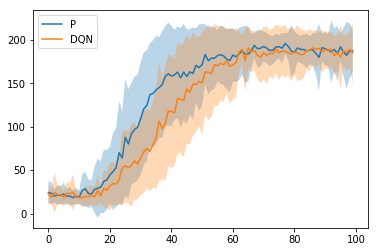

In [12]:
import matplotlib.pyplot as plt
P_scoress_np = np.array(P_scoress)
dqn_scoress_np = np.array(dqn_scoress)
plt.plot(P_episodess[0], mean_P_scores, label="P")
plt.plot(dqn_episodess[0], mean_dqn_scores, label = "DQN")
plt.fill_between(P_episodess[0], mean_P_scores-P_scoress_np.std(axis=0), mean_P_scores+P_scoress_np.std(axis=0), alpha=0.3)
plt.fill_between(dqn_episodess[0], mean_dqn_scores-dqn_scoress_np.std(axis=0), mean_dqn_scores+dqn_scoress_np.std(axis=0), alpha=0.3)
plt.legend()
plt.show()

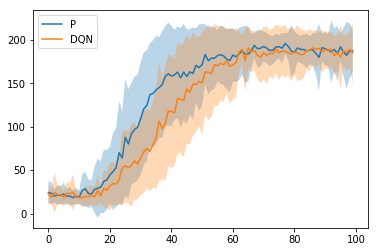

In [14]:
np.save('carpole_trained_P', P_scoress)
np.save('carpole_trained_dqn', dqn_scoress)
P_scoress_load = np.load('carpole_trained_P.npy')
dqn_scoress_load = np.load('carpole_trained_dqn.npy')

P_scoress_np = np.array(P_scoress_load)
dqn_scoress_np = np.array(dqn_scoress_load)

mean_P_scores = np.zeros(len(P_scoress_load[0]))
for P_scores in P_scoress:
    mean_P_scores += np.array(P_scores)
mean_P_scores /= len(P_scoress)

mean_dqn_scores = np.zeros(len(dqn_scoress_load[0]))
for dqn_scores in dqn_scoress:
    mean_dqn_scores += np.array(dqn_scores)
mean_dqn_scores /= len(dqn_scoress)

plt.plot(P_episodess[0], mean_P_scores, label="P")
plt.plot(dqn_episodess[0], mean_dqn_scores, label = "DQN")
#plt.plot(P_episodess[0], np.median(np.array(P_scoress), axis=0), label="P")
#plt.plot(dqn_episodess[0], np.median(np.array(dqn_scoress), axis=0), label = "DQN")

plt.fill_between(P_episodess[0], mean_P_scores-P_scoress_np.std(axis=0), mean_P_scores+P_scoress_np.std(axis=0), alpha=0.3)
plt.fill_between(dqn_episodess[0], mean_dqn_scores-dqn_scoress_np.std(axis=0), mean_dqn_scores+dqn_scoress_np.std(axis=0), alpha=0.3)
plt.legend()
plt.show()